In [18]:
from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_eBOSS_QSO
import mapper_CMBK
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp

In [19]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
nside_mask = 512
bands = nmt.NmtBin.from_nside_linear(nside, 20)
ell_arr = bands.get_effective_ells()

In [20]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask }

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask  }

SGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask }

SGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask  }

In [21]:
NGC_1_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_1_config)
NGC_2_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_2_config)
SGC_1_maps = mapper_eBOSS_QSO.MappereBOSSQSO(SGC_1_config)
SGC_2_maps = mapper_eBOSS_QSO.MappereBOSSQSO(SGC_2_config)

In [22]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
b_ngc = 2.37*np.ones(200) 
b_sgc = 2.32 *np.ones(200) 

In [23]:
NGC_nz_1 = NGC_1_maps.get_nz()
NGC_nz_2 = NGC_2_maps.get_nz()
SGC_nz_1 = SGC_1_maps.get_nz()
SGC_nz_2 = SGC_2_maps.get_nz()

In [24]:
NGC_z_1 = NGC_nz_1[1]
NGC_dNdz_1 = NGC_nz_1[0]

NGC_z_2 = NGC_nz_2[1]
NGC_dNdz_2 = NGC_nz_2[0]

In [25]:
SGC_z_1 = SGC_nz_1[1]
SGC_dNdz_1 = SGC_nz_1[0]

SGC_z_2 = SGC_nz_2[1]
SGC_dNdz_2 = SGC_nz_2[0]

In [9]:
NGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_1,NGC_dNdz_1), bias=(NGC_z_1,b_ngc))
NGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_2,NGC_dNdz_2), bias=(NGC_z_2,b_ngc))

In [10]:
SGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_1,NGC_dNdz_1), bias=(SGC_z_1,b_ngc))
SGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_2,NGC_dNdz_2), bias=(SGC_z_2,b_ngc))

In [11]:
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)

In [12]:
#ell = np.arange(2, 2000)
NGC_theory_11 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar1, ell_arr) 
NGC_theory_12 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar2, ell_arr) 
NGC_theory_22 = ccl.angular_cl(cosmo, NGC_quasar2, NGC_quasar2, ell_arr) 

SGC_theory_11 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar1, ell_arr) 
SGC_theory_12 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar2, ell_arr) 
SGC_theory_22 = ccl.angular_cl(cosmo, SGC_quasar2, SGC_quasar2, ell_arr) 

NGC_shear_theory_1 = ccl.angular_cl(cosmo, CMB_shear, NGC_quasar1, ell_arr) 
NGC_shear_theory_2 = ccl.angular_cl(cosmo, CMB_shear, NGC_quasar2, ell_arr) 
SGC_shear_theory_1 = ccl.angular_cl(cosmo, CMB_shear, SGC_quasar1, ell_arr) 
SGC_shear_theory_2 = ccl.angular_cl(cosmo, CMB_shear, SGC_quasar2, ell_arr) 


In [13]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [14]:
# Read healpix maps and initialize a spin-0 and spin-2 field
NGC_delta_1 = NGC_1_maps.get_signal_map()
NGC_delta_2 = NGC_2_maps.get_signal_map() 
NGC_mask_1  = NGC_1_maps.get_mask()
NGC_mask_2  = NGC_2_maps.get_mask() 

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

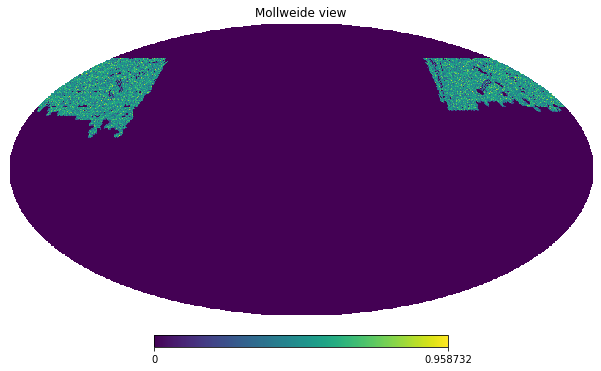

In [17]:
hp.visufunc.mollview(NGC_mask_2)

In [12]:
# Read healpix maps and initialize a spin-0 and spin-2 field
SGC_delta_1 = SGC_1_maps.get_signal_map()
SGC_delta_2 = SGC_2_maps.get_signal_map() 
SGC_mask_1  = SGC_1_maps.get_mask()
SGC_mask_2  = SGC_2_maps.get_mask() 

In [13]:
NGC_f_1 =  NGC_1_maps.get_nmt_field(NGC_delta_1, NGC_mask_1)
NGC_f_2 =  NGC_2_maps.get_nmt_field(NGC_delta_2, NGC_mask_2)

In [14]:
SGC_f_1 =  SGC_1_maps.get_nmt_field(SGC_delta_1, SGC_mask_1)
SGC_f_2 =  SGC_2_maps.get_nmt_field(SGC_delta_2, SGC_mask_2)

In [15]:
NGC_w_11 = nmt.NmtWorkspace()
NGC_w_11.compute_coupling_matrix(NGC_f_1, NGC_f_1, bands)
      
NGC_w_12 = nmt.NmtWorkspace()
NGC_w_12.compute_coupling_matrix(NGC_f_1, NGC_f_2, bands)

NGC_w_22 = nmt.NmtWorkspace()
NGC_w_22.compute_coupling_matrix(NGC_f_2, NGC_f_2, bands)

In [45]:
SGC_w_11 = nmt.NmtWorkspace()
SGC_w_11.compute_coupling_matrix(SGC_f_1, SGC_f_1, bands)

SGC_w_12 = nmt.NmtWorkspace()
SGC_w_12.compute_coupling_matrix(SGC_f_1, SGC_f_2, bands)

SGC_w_22 = nmt.NmtWorkspace()
SGC_w_22.compute_coupling_matrix(SGC_f_2, SGC_f_2, bands)

In [16]:
NGC_empirical_11 = compute_cl(NGC_f_1, NGC_f_1, NGC_w_11)
NGC_empirical_12 = compute_cl(NGC_f_1, NGC_f_2, NGC_w_12)
NGC_empirical_22 = compute_cl(NGC_f_2, NGC_f_2, NGC_w_22)

In [65]:
SGC_empirical_11 = compute_cl(SGC_f_1, SGC_f_1, SGC_w_11)
SGC_empirical_12 = compute_cl(SGC_f_1, SGC_f_2, SGC_w_12)
SGC_empirical_22 = compute_cl(SGC_f_2, SGC_f_2, SGC_w_22)

In [66]:
NGC_nl_11 = NGC_1_maps.get_nl_coupled() 
NGC_nl_22 = NGC_2_maps.get_nl_coupled() 

NGC_nl_11 = NGC_w_11.decouple_cell(NGC_nl_11)
NGC_nl_22 = NGC_w_22.decouple_cell(NGC_nl_22)

In [75]:
SGC_nl_11 = SGC_1_maps.get_nl_coupled() 
SGC_nl_22 = SGC_2_maps.get_nl_coupled() 

SGC_nl_11 = SGC_w_11.decouple_cell(SGC_nl_11)
SGC_nl_22 = SGC_w_22.decouple_cell(SGC_nl_22)

In [76]:
NGC_nn_empirical_11 = NGC_empirical_11 - NGC_nl_11
NGC_nn_empirical_22 = NGC_empirical_22 - NGC_nl_22

In [77]:
SGC_nn_empirical_11 = SGC_empirical_11 - SGC_nl_11
SGC_nn_empirical_22 = SGC_empirical_22 - SGC_nl_22

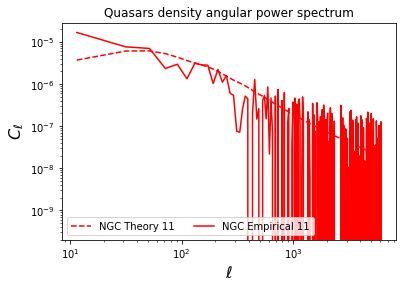

In [84]:
plt.plot(ell_arr, NGC_theory_11, 'r--', label='NGC Theory 11')
plt.plot(ell_arr, NGC_nn_empirical_11[0], 'r-', label='NGC Empirical 11')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

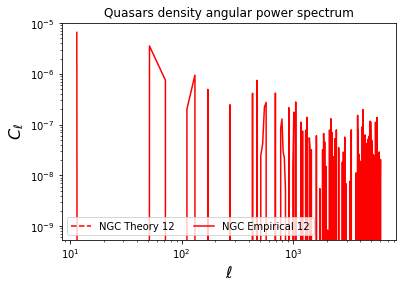

In [90]:
plt.plot(ell_arr, NGC_theory_12, 'r--', label='NGC Theory 12')
plt.plot(ell_arr, NGC_empirical_12[0], 'r-', label='NGC Empirical 12')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

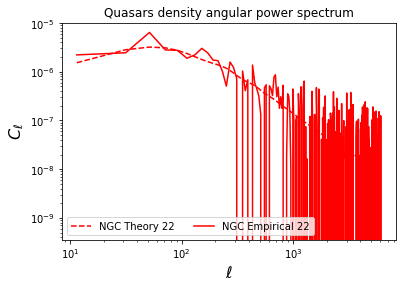

In [86]:
plt.plot(ell_arr, NGC_theory_22, 'r--', label='NGC Theory 22')
plt.plot(ell_arr, NGC_nn_empirical_22[0], 'r-', label='NGC Empirical 22')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

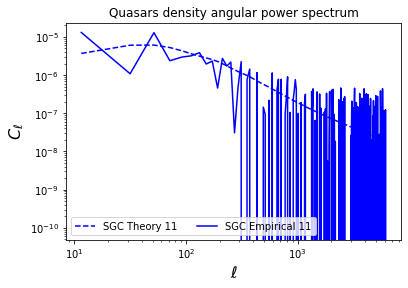

In [87]:
plt.plot(ell_arr, SGC_theory_11, 'b--', label='SGC Theory 11')
plt.plot(ell_arr, SGC_nn_empirical_11[0], 'b-', label='SGC Empirical 11')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

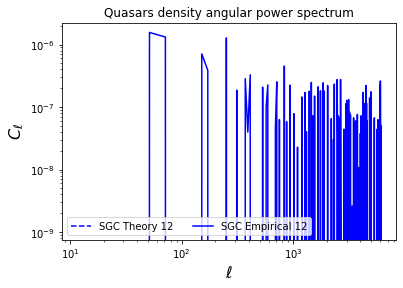

In [91]:
plt.plot(ell_arr, SGC_theory_12, 'b--', label='SGC Theory 12')
plt.plot(ell_arr, SGC_empirical_12[0], 'b-', label='SGC Empirical 12')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

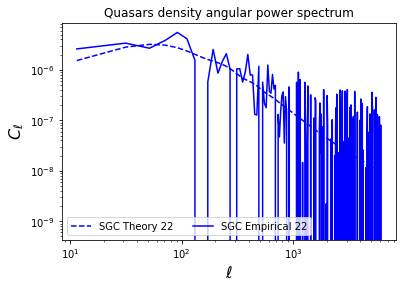

In [89]:
plt.plot(ell_arr, SGC_theory_22, 'b--', label='SGC Theory 22')
plt.plot(ell_arr, SGC_nn_empirical_22[0], 'b-', label='SGC Empirical 22')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

# Test cross-correlation

In [21]:
CMBK_config = {'data_klm':['/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits'], 
          'data_mask':['/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz'],
               'data_noise':['/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat'],
          'nside':nside}

In [22]:
CMBK_maps = mapper_CMBK.MapperCMBK(CMBK_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [23]:
signal = CMBK_maps.get_signal_map()
mask = CMBK_maps.get_mask()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [25]:
NGC1_k_w = nmt.NmtWorkspace()
NGC1_k_w.compute_coupling_matrix(NGC_f_1, CMBK_f, bands)

NGC2_k_w = nmt.NmtWorkspace()
NGC2_k_w.compute_coupling_matrix(NGC_f_2, CMBK_f, bands)

In [26]:
SGC1_k_w = nmt.NmtWorkspace()
SGC1_k_w.compute_coupling_matrix(SGC_f_1, CMBK_f, bands)

SGC2_k_w = nmt.NmtWorkspace()
SGC2_k_w.compute_coupling_matrix(SGC_f_2, CMBK_f, bands)

In [27]:
NGC1_k = compute_cl(NGC_f_1, CMBK_f, NGC1_k_w)
NGC2_k = compute_cl(NGC_f_2, CMBK_f, NGC2_k_w)

In [28]:
SGC1_k = compute_cl(SGC_f_1, CMBK_f, SGC1_k_w)
SGC2_k = compute_cl(SGC_f_2, CMBK_f, SGC2_k_w)

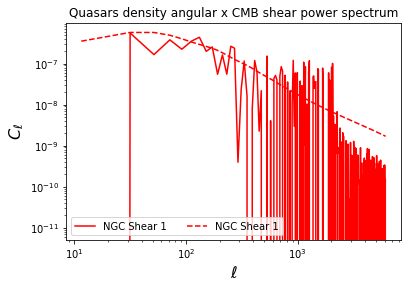

In [100]:
plt.plot(ell_arr, NGC1_k[0], 'r-', label='NGC Shear 1')
plt.plot(ell_arr, NGC_shear_theory_1, 'r--', label='Theory')

plt.loglog()
plt.title('Quasars density angular x CMB shear power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

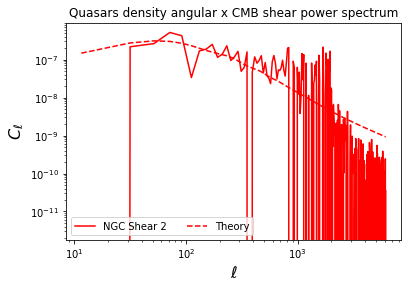

In [101]:
plt.plot(ell_arr, NGC2_k[0], 'r-', label='NGC Shear 2')
plt.plot(ell_arr, NGC_shear_theory_2, 'r--', label='Theory')
plt.loglog()
plt.title('Quasars density angular x CMB shear power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

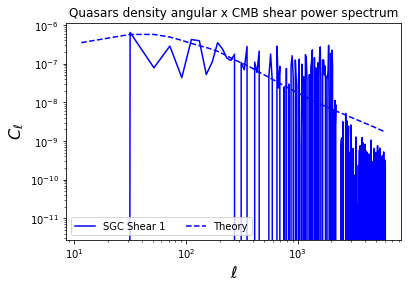

In [102]:
plt.plot(ell_arr, SGC1_k[0], 'b-', label='SGC Shear 1')
plt.plot(ell_arr, SGC_shear_theory_1, 'b--', label='Theory')

plt.loglog()
plt.title('Quasars density angular x CMB shear power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

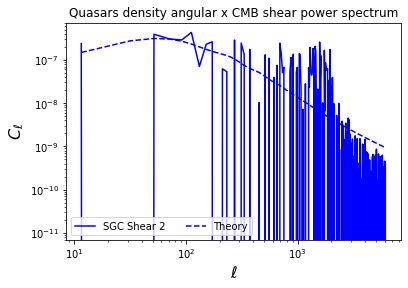

In [103]:
plt.plot(ell_arr, SGC2_k[0], 'b-', label='SGC Shear 2')
plt.plot(ell_arr, SGC_shear_theory_2, 'b--', label='Theory')

plt.loglog()
plt.title('Quasars density angular x CMB shear power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [43]:
NGC1_k_w.write_to('wsp_NGC_1_CMBK.fits')
NGC2_k_w.write_to('wsp_NGC_2_CMBK.fits')
SGC1_k_w.write_to('wsp_SGC_1_CMBK.fits')
SGC2_k_w.write_to('wsp_SGC_2_CMBK.fits')

In [44]:
NGC_w_11.write_to('wsp_NGC_11.fits')
NGC_w_12.write_to('wsp_NGC_12.fits')
NGC_w_22.write_to('wsp_NGC_22.fits')

In [46]:
SGC_w_11.write_to('wsp_SGC_11.fits')
SGC_w_12.write_to('wsp_SGC_12.fits')
sGC_w_22.write_to('wsp_SGC_22.fits')

NameError: name 'sGC_w_22' is not defined